## Data Analysis Challenge

In [211]:
# import libraries

import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import seaborn as sns
plt.style.use('seaborn')
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


### Part 1 ‐ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15­minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.


In [2]:
# open file
with open('logins.json') as f:
    raw_data = json.load(f)
    
logins_series = pd.Series(raw_data['login_time'])
logins_datetime = pd.to_datetime(logins_series,infer_datetime_format=True)

In [3]:
logins_datetime.isnull().values.any()

False

In [4]:
df = pd.DataFrame({'time':logins_datetime,'month':logins_datetime.dt.month_name(),'week':logins_datetime.dt.week,
                   'day':logins_datetime.dt.day, 'dayofyear':logins_datetime.dt.dayofyear,
                   'weekday':logins_datetime.dt.weekday_name,'hour':logins_datetime.dt.hour,'minute':logins_datetime.dt.minute})
df.tail()

,time,month,week,day,dayofyear,weekday,hour,minute
93137,1970-04-13 18:50:19,April,16,13,103,Monday,18,50
93138,1970-04-13 18:43:56,April,16,13,103,Monday,18,43
93139,1970-04-13 18:54:02,April,16,13,103,Monday,18,54
93140,1970-04-13 18:57:38,April,16,13,103,Monday,18,57
93141,1970-04-13 18:54:23,April,16,13,103,Monday,18,54


In [7]:
# function to aggregate login counts based on 15 minute intervals
def round_minutes(minute):
    if minute >= 45:
        return 45
    elif minute >= 30:
        return 30
    elif minute >= 15:
        return 15
    else:
        return 0

In [8]:
# aggregate login counts based on 15 minute intervals
df['minute'] = df.minute.apply(round_minutes)
df.tail()

,time,month,week,day,dayofyear,weekday,hour,minute
93137,1970-04-13 18:50:19,April,16,13,103,Monday,18,45
93138,1970-04-13 18:43:56,April,16,13,103,Monday,18,30
93139,1970-04-13 18:54:02,April,16,13,103,Monday,18,45
93140,1970-04-13 18:57:38,April,16,13,103,Monday,18,45
93141,1970-04-13 18:54:23,April,16,13,103,Monday,18,45


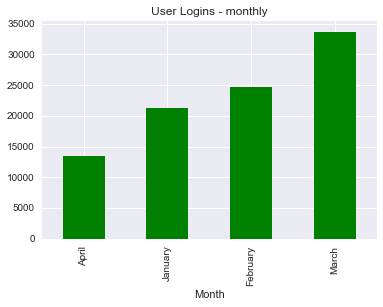

In [16]:
# number of logins monthly
df.groupby('month')['month'].count().sort_values().plot(kind='bar',color='g')
plt.title('User Logins - monthly')
plt.xlabel('Month')
plt.show()

#### The plot above shows highest user logins in the month of March. We can see the increasing trend from January to March and decline in April is due to lack of data after the 16th.

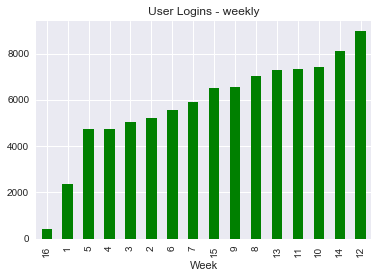

In [27]:
# number of logins weekly
df.groupby('week')['week'].count().sort_values().plot(kind='bar',color='g')
plt.title('User Logins - weekly')
plt.xlabel('Week')
plt.show()

#### The plot above shows highest user logins in the week 12 - the last week of March.

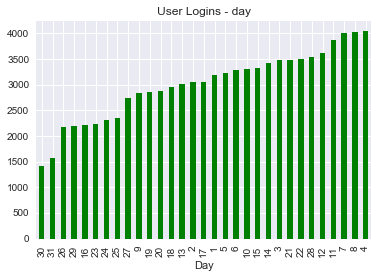

In [28]:
# number of logins by day (all months inclusive)
df.groupby('day')['day'].count().sort_values().plot(kind='bar',color='g')
plt.title('User Logins - day')
plt.xlabel('Day')
plt.show()

#### For some reason the data shows highest number of user logins on the day 4 inclusive of all months. Is it just casuality? If needed we should investigate the reasons behind it.

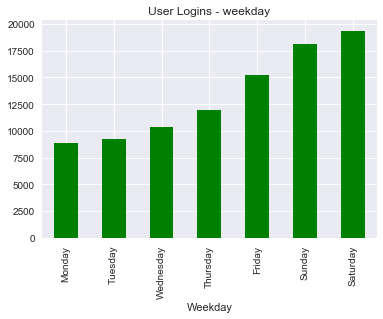

In [29]:
# number of logins weekday (all months inclusive)
df.groupby('weekday')['weekday'].count().sort_values().plot(kind='bar',color='g')
plt.title('User Logins - weekday')
plt.xlabel('Weekday')
plt.show()

#### The plot above shows highest user logins on Saturday and Sunday which is expected as people driving to and fro on weekends.

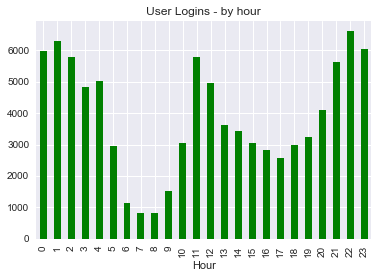

In [32]:
# number of logins hourly (all months inclusive)
df.groupby(['hour'])['hour'].count().plot(kind='bar',color='g')
plt.title('User Logins - by hour')
plt.xlabel('Hour')
plt.show()

#### The plot above shows highest user logins peak around 11 am and 10 pm with gradual increase from 4pm to 10pm.

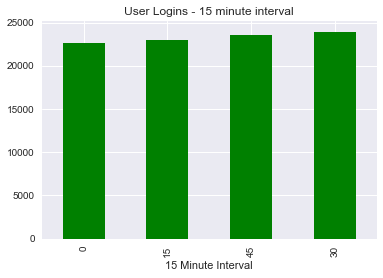

In [33]:
# number of logins - 15 minute interval
df.groupby('minute')['minute'].count().sort_values().plot(kind='bar',color='g')
plt.title('User Logins - 15 minute interval')
plt.xlabel('15 Minute Interval')
plt.show()

#### The plot above shows maximum user logins at 30 minute intervals.

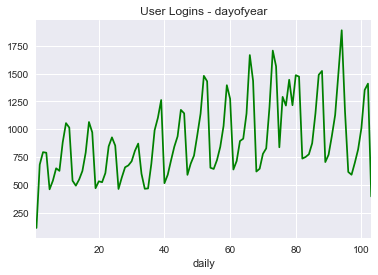

In [24]:
# number of logins - daily
df.groupby('dayofyear')['dayofyear'].count().plot(color='g')
plt.title('User Logins - dayofyear')
plt.xlabel('daily')
plt.show()

In [42]:
df_day = pd.DataFrame({'count' : df.groupby( [ "dayofyear"] ).size()}).reset_index()
df_day

,dayofyear,count
0,1,112
1,2,681
2,3,793
3,4,788
4,5,459
...,...,...
98,99,818
99,100,1009
100,101,1352
101,102,1409


Text(0.5, 6.799999999999994, 'Day')

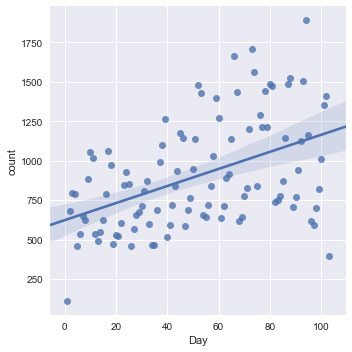

In [46]:
sns.lmplot(data=df_day,x='dayofyear',y='count')
plt.xlabel('Day')

In [78]:
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression().fit(df_day['dayofyear'].values.reshape(-1,1),df_day['count'])

In [83]:
#To retrieve the intercept:
print('intercept:', lin_model.intercept_)
#For retrieving the slope:
print('slope: ',lin_model.coef_)

intercept: 622.7624214734437
slope:  [5.41401617]


In [84]:
#Get the coefficient of determination
r_sq = lin_model.score(df_day['dayofyear'].values.reshape(-1,1),df_day['count'])
print('coefficient of determination:', r_sq)

coefficient of determination: 0.21709528030075298


#### This is a weak correlation but still showing an increasing trend.

### Part 2 ‐ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

### Answers:        

#### 1. What would you choose as the key measure of success of this experiment in encouraging driver partners to ####serve both cities, and why would you choose this metric?        

Proposed experiment: Reimburse all toll costs to overcome driver partners tendency of being exclusive to each city.   
I would choose the profit earned as the key measure of success of this experiment because,       
----Ultimate Gotham being most active at night, and Ultimate Metropolis being most active during the day might affect the availability of number of drivers and also the drivers may not be intersted in paying the toll.   
----By reimbursing the toll money some drivers might consider not being exclusive to any city as they make more profit.

If the drivers make more profit and take more trips after the experiment we can consider the experiment as successful. We can set a threshold of 20% increase in profit and if there is 20% increase in the profit we can consider the experiment successful.

#### 2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on: a. how you will implement the experiment b. what statistical test(s) you will conduct to verify the significance of the observation c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.

The (statistical) design of experiments (DOE) is an efficient procedure for planning experiments so that the data obtained can be analyzed to yield valid and objective conclusions. Experimental Design is organizing the way in which one changes one or more input variables (Xs) to see if any of the variables, or any combination of those variables, affects the output (Y) in a significant way.
Strategy for Experimentation

Experimentation steps:
Hypothesis:
H0: Reimbursing the toll costs does not increase the profit.
H1: Reimbursing the toll costs increase the profit.

First we randomly select control and treatment groups of drivers from both Ultimate Gotham and Ultimate Metropolis for our experiment. We can set the experiment period to be three months. For those three months one group is being reimbursed for the toll costs while the other group is not. Then, we measure the the number of trips taken by the drivers of both groups and the profits earned by the drivers of both groups. Now we can calculate the overall profit earned by both groups and compare agaist each other. If there is significant increase in the number of trips and profit earned by the group that was reimbursed we can say that the experiment was successful and the alternate hypothesis becomes true. A t-test or z-test would prove it. Several other factors might influence the results as well like user feedback, wait times etc.

Recommendations: Alternate hypothesis if true shows reimbursement driver partners tendency of being exclusive to each city can be overcome. To reduce the cost for the city operations we could study further and decide on certain time periods when the trips peak and only reimburse for those times, study the types of vehicles taking trips and accordingly reimburse only for those types, or reimburse only drivers taking trips over the threshold limit in a given period.

### Data description
● city: city this user signed up in      
● phone: primary device for this user       
● signup_date: date of account registration; in the form ‘YYYYMMDD’         
● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’       
● avg_dist: the average distance in miles per trip taken in the first 30 days after signup      
● avg_rating_by_driver: the rider’s average rating over all of their trips       
● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips      
● surge_pct: the percent of trips taken with surge multiplier > 1       
● avg_surge: The average surge multiplier over all of this user’s trips       
● trips_in_first_30_days: the number of trips this user took in the first 30 days after
signing up         
● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;
FALSE otherwise                 
● weekday_pct: the percent of the user’s trips occurring during a weekday

### Part 3 ‐ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).

In [132]:
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)
ult_df = pd.DataFrame(data)

In [133]:
ult_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [134]:
ult_df['signup_date'] = pd.to_datetime(ult_df['signup_date'])
ult_df['last_trip_date'] = pd.to_datetime(ult_df['last_trip_date'])

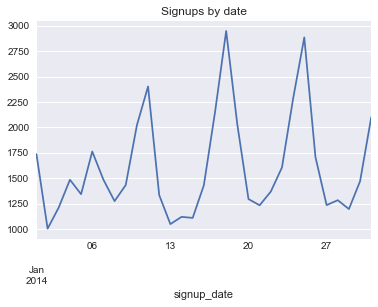

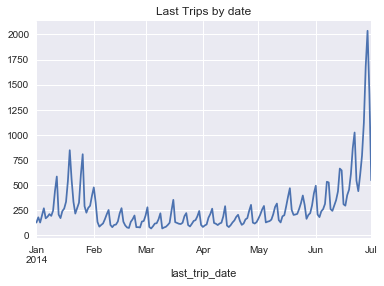

In [135]:
ult_df.groupby('signup_date').size().plot()
plt.title('Signups by date')
plt.show()
ult_df.groupby('last_trip_date').size().plot()
plt.title('Last Trips by date')
plt.show()

In [136]:
# Display the date the last trip was taken
ult_df.last_trip_date.max()

Timestamp('2014-07-01 00:00:00')

#### As we can see the data the last trip was taken is 2014-07-01. So we will assume the user is retained if the users last trip is greater than or equal to 2014-06-01.

#### We will create a column retained that will hold a boolean

In [137]:
ult_df['retained'] = (ult_df.last_trip_date >= '2014-06-01')

In [138]:
ult_df.retained.head()

0     True
1    False
2    False
3     True
4    False
Name: retained, dtype: bool

In [205]:
print('Percentage of users retained: {:.1f}%'.format(ult_df.retained.sum()*100/ult_df.shape[0]))

Percentage of users retained: 37.6%


Text(0.5, 0, '% Trips on Weekday')

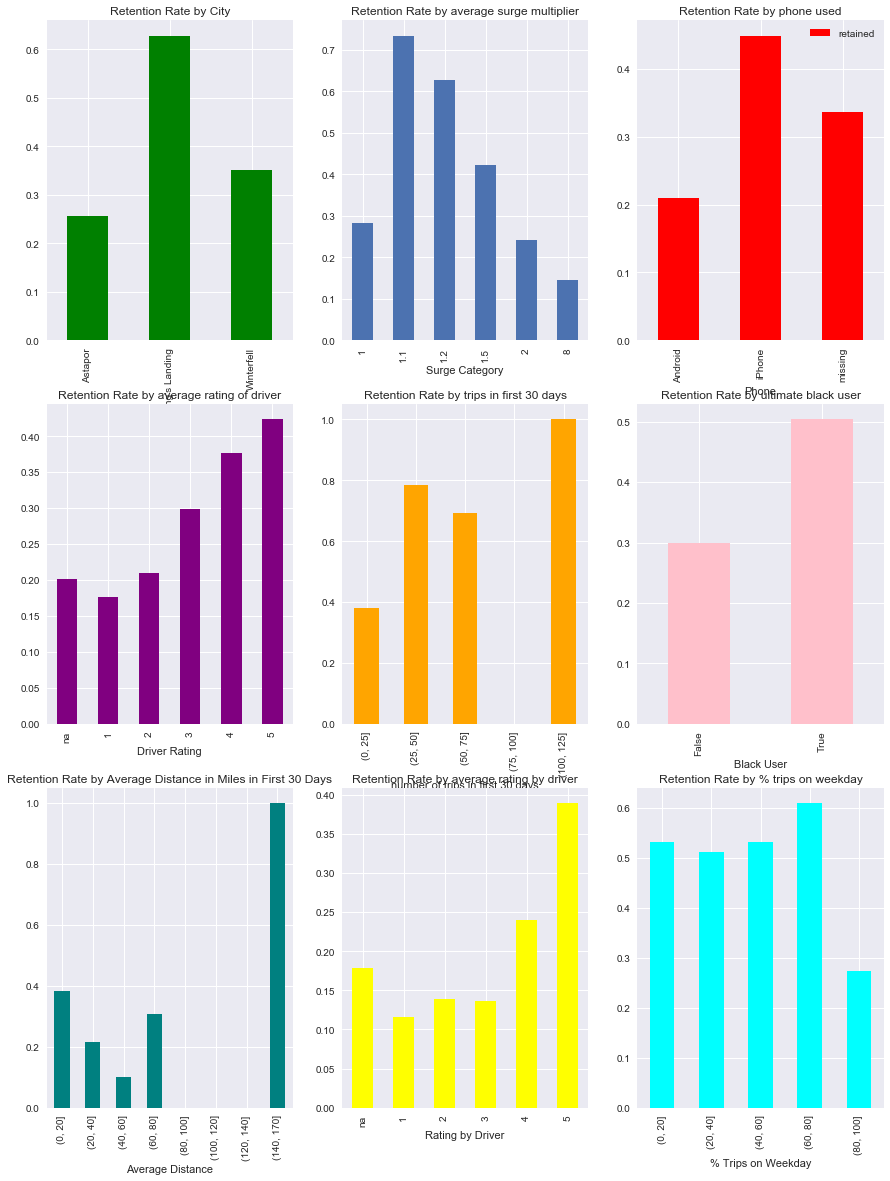

In [204]:
# Plots to view retention rates based on different circumstances
f, axes = plt.subplots(nrows=3,ncols=3, figsize=(15, 20))
ult_df.groupby('city')['retained'].mean().plot(kind='bar',ax=axes[0][0],color='g')
axes[0][0].set_title("Retention Rate by City")
axes[0][0].set_xlabel('City')
ult_df['surge_cat'] = pd.cut(ult_df['avg_surge'], 
                         (0, 1, 1.1, 1.2, 1.5, 2, 8),
                         labels=['1', '1.1', '1.2', '1.5', '2', '8'])
ult_df.groupby('surge_cat')['retained'].mean().plot(kind='bar',ax=axes[0][1])
axes[0][1].set_title("Retention Rate by average surge multiplier")
axes[0][1].set_xlabel('Surge Category')
ult_df[['retained', 'phone']].fillna('missing').groupby('phone').mean().plot(kind='bar',ax=axes[0][2],color='r')
axes[0][2].set_title("Retention Rate by phone used")
axes[0][2].set_xlabel('Phone')
ult_df['rating_of_driver_cat'] = pd.cut(ult_df['avg_rating_of_driver'].fillna(-99), (-100, 0, 1, 2, 3, 4, 5),
                                    labels=['na', '1', '2', '3' ,'4', '5'])
ult_df.groupby('rating_of_driver_cat')['retained'].mean().plot(kind='bar',ax=axes[1][0],color='purple')
axes[1][0].set_title("Retention Rate by average rating of driver")
axes[1][0].set_xlabel('Driver Rating')
ult_df['trips_in_first_30_cat'] = pd.cut(ult_df['trips_in_first_30_days'].fillna(0), (0, 25, 50, 75, 100, 125))
ult_df.groupby('trips_in_first_30_cat')['retained'].mean().plot(kind='bar',ax=axes[1][1],color='orange')
axes[1][1].set_title("Retention Rate by trips in first 30 days")
axes[1][1].set_xlabel('number of trips in first 30 days')
ult_df.groupby('ultimate_black_user')['retained'].mean().plot(kind='bar',ax=axes[1][2],color='pink')
axes[1][2].set_title('Retention Rate by ultimate black user')
axes[1][2].set_xlabel('Black User')
ult_df['avg_dist_cat'] = pd.cut(ult_df['avg_dist'].fillna(0), (0,20,40,60,80,100,120,140,170))
ult_df.groupby('avg_dist_cat')['retained'].mean().plot(kind='bar',ax=axes[2][0],color='teal')
axes[2][0].set_title("Retention Rate by Average Distance in Miles in First 30 Days")
axes[2][0].set_xlabel('Average Distance')
ult_df['rating_by_driver_cat'] = pd.cut(ult_df['avg_rating_by_driver'].fillna(-99), (-100, 0, 1, 2, 3, 4, 5),
                                    labels=['na', '1', '2', '3' ,'4', '5'])
ult_df.groupby('rating_by_driver_cat')['retained'].mean().plot(kind='bar',ax=axes[2][1],color='yellow')
axes[2][1].set_title("Retention Rate by average rating by driver")
axes[2][1].set_xlabel('Rating by Driver')
ult_df['weekday_pct_cat'] = pd.cut(ult_df['weekday_pct'].fillna(0), (0,20,40,60,80,100))
ult_df.groupby('weekday_pct_cat')['retained'].mean().plot(kind='bar',ax=axes[2][2],color='cyan')
axes[2][2].set_title("Retention Rate by % trips on weekday")
axes[2][2].set_xlabel('% Trips on Weekday')

In [208]:
X = pd.get_dummies(ult_df[['city', 'phone', 'ultimate_black_user', 'weekday_pct', 
                                'rating_by_driver_cat', 'trips_in_first_30_cat',
                               'rating_of_driver_cat','surge_cat']], drop_first=True)

In [209]:
y = ult_df.retained

### Model evaluation using default parameters

In [212]:
clf = LogisticRegression(n_jobs=-1)
clf.fit(X, y)

/Users/priyasathish/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/priyasathish/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [214]:
from sklearn.model_selection import train_test_split
#split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=42)

In [266]:
from sklearn.metrics import confusion_matrix
cm_dict = {}
#Creating a dict of the models
model_dict = {'Dummy' : DummyClassifier(random_state=3),
              'Stochastic Gradient Descent' : SGDClassifier(random_state=3, loss='log'),
              'Random Forest': RandomForestClassifier(random_state=3),
              'Decsision Tree': DecisionTreeClassifier(random_state=3),
              'AdaBoost': AdaBoostClassifier(random_state=3),
              'Gaussian Naive Bayes': GaussianNB(),
              'Logistic Regression': LogisticRegression(n_jobs = -1),
              'LinearSVM': LinearSVC(),
              'K Nearest Neighbor': KNeighborsClassifier()}


#Function to get the scores for each model in a df
def model_score_df(model_dict):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        cm = confusion_matrix(y_test,y_pred)
        cm_dict[k]=cm
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df

results_df = model_score_df(model_dict)

/Users/priyasathish/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/priyasathish/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/priyasathish/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/priyasathish/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [267]:
results_df

,model_name,accuracy_score,precision_score,recall_score,f1_score
4,AdaBoost,0.7656,0.75269,0.740212,0.744941
8,K Nearest Neighbor,0.7449,0.728656,0.726265,0.727381
2,Random Forest,0.7532,0.74276,0.718319,0.725396
3,Decsision Tree,0.7518,0.743348,0.713564,0.721303
6,Logistic Regression,0.7405,0.724989,0.711944,0.716546
5,Gaussian Naive Bayes,0.7086,0.695654,0.704182,0.69771
7,LinearSVM,0.7368,0.749148,0.677191,0.68374
0,Dummy,0.5362,0.504602,0.504557,0.504536
1,Stochastic Gradient Descent,0.645,0.646148,0.544856,0.496096


In [268]:
# function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
 

In [269]:
cm_dict

{'Dummy': array([[3945, 2274],
        [2364, 1417]]), 'Stochastic Gradient Descent': array([[5943,  276],
        [3274,  507]]), 'Random Forest': array([[5357,  862],
        [1606, 2175]]), 'Decsision Tree': array([[5413,  806],
        [1676, 2105]]), 'AdaBoost': array([[5251,  968],
        [1376, 2405]]), 'Gaussian Naive Bayes': array([[4492, 1727],
        [1187, 2594]]), 'Logistic Regression': array([[5156, 1063],
        [1532, 2249]]), 'LinearSVM': array([[5732,  487],
        [2145, 1636]]), 'K Nearest Neighbor': array([[4992, 1227],
        [1324, 2457]])}

Normalized confusion matrix
[[0.63434636 0.36565364]
 [0.62523142 0.37476858]]
Normalized confusion matrix
[[0.95561987 0.04438013]
 [0.86590849 0.13409151]]
Normalized confusion matrix
[[0.86139251 0.13860749]
 [0.42475536 0.57524464]]
Normalized confusion matrix
[[0.87039717 0.12960283]
 [0.44326898 0.55673102]]
Normalized confusion matrix
[[0.84434797 0.15565203]
 [0.36392489 0.63607511]]
Normalized confusion matrix
[[0.72230262 0.27769738]
 [0.31393811 0.68606189]]
Normalized confusion matrix
[[0.8290722  0.1709278 ]
 [0.40518381 0.59481619]]
Normalized confusion matrix
[[0.92169159 0.07830841]
 [0.56731024 0.43268976]]
Normalized confusion matrix
[[0.8027014  0.1972986 ]
 [0.35017191 0.64982809]]


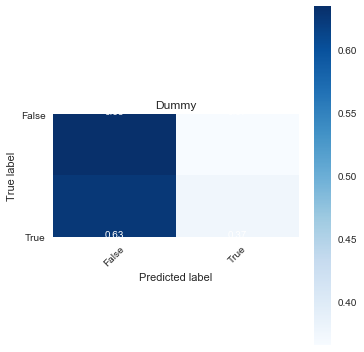

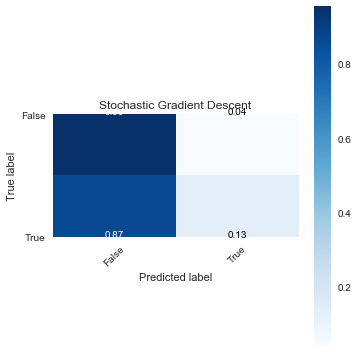

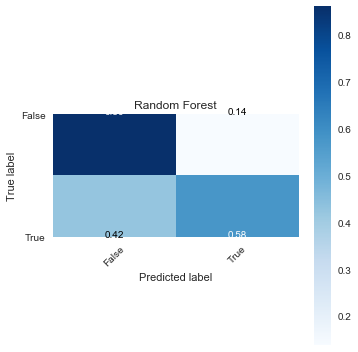

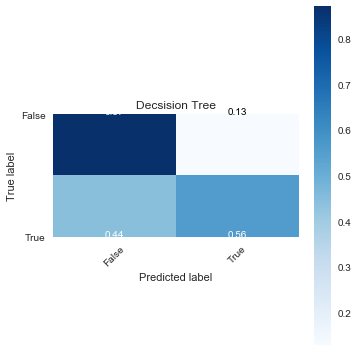

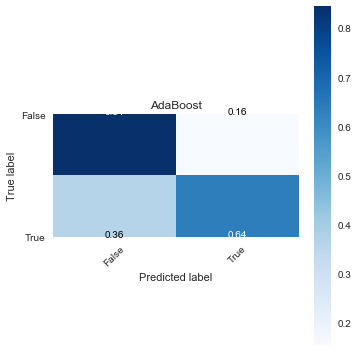

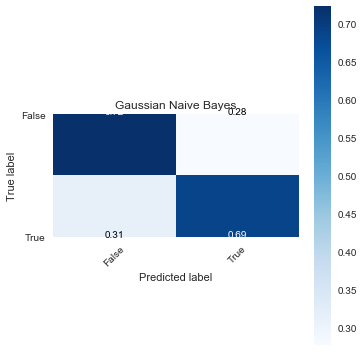

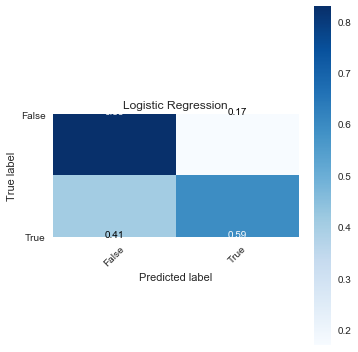

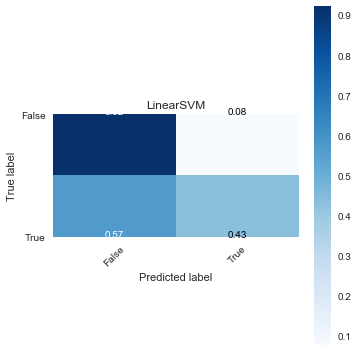

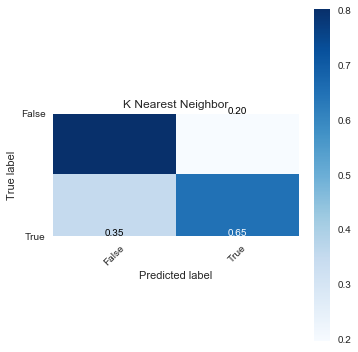

In [270]:
for k, v in cm_dict.items():
    plot_confusion_matrix(v, classes,
                      normalize= True,  title=k)

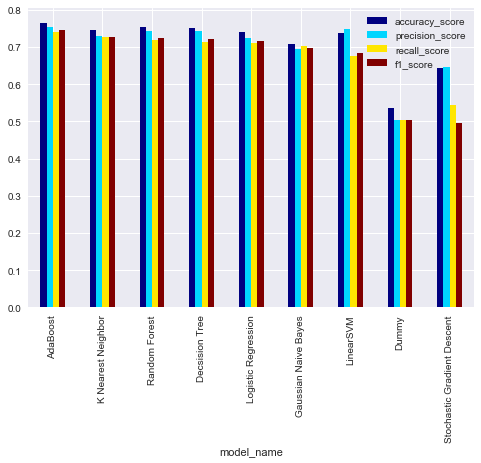

In [276]:
results_df.plot(kind='bar',x='model_name',colormap='jet')

### Conclusion:    

Tried implementing several models and from the plot above we can see the top four models are,
#### AdaBoost, K Nearest Neighbor, Random Forest and Decsision Tree with each one giving an accuracy of about 75% and f1 score of about 75%. 

These predictions from the preliminary models are not that bad and we could go deeper considering features with high importance and fine tune our models to get better predictions. Depending on our findings with feature importance we can suggest incentives based for those features which will help user retention.   

For example, provide benefits to the user using the app on weekends, provide incentives to users taking trips on weekends and in their first month after signup, provide incentives based on the number of trips taken etc. These recommendations will certainly increase the chance of user retention over 6 months. 